In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/Dataset/Healthy_3_0.csv
/kaggle/input/dataset/Dataset/Copy of Testing_file1.csv
/kaggle/input/dataset/Dataset/Ballfault_00028.csv
/kaggle/input/dataset/Dataset/BallFault_0007.csv
/kaggle/input/dataset/Dataset/Innerfault_0007.xlsx.csv
/kaggle/input/dataset/Dataset/Innerfault_00028.csv
/kaggle/input/dataset/Dataset/ground_truth.xlsx.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import os


data_dir = '/kaggle/input/dataset/Dataset' 
ground_truth_path = '/kaggle/input/dataset/Dataset/ground_truth.xlsx.csv' 


ground_truth_df = pd.read_csv(ground_truth_path)

# Function to extract basic time-domain features
def extract_features(data):
    features = {
        'mean': np.mean(data, axis=1),
        'variance': np.var(data, axis=1),
        'kurtosis': pd.DataFrame(data).kurtosis(axis=1),
        'peak_amplitude': np.max(np.abs(data), axis=1)
    }
    return pd.DataFrame(features)

# Initializing lists for features and labels
X = []
y = []

# Process each file in the dataset directory
for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        label = file.split('_')[0]  
        file_path = os.path.join(data_dir, file)
        
        
        data = pd.read_csv(file_path, header=None)
        data = data.apply(pd.to_numeric, errors='coerce').dropna()  
        features = extract_features(data.values)  
        
        # Append features and corresponding label
        X.append(features)
        y += [label] * len(features)

# Combine features and labels
X = pd.concat(X, ignore_index=True)
y = pd.Series(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training model and calculating F1 score
model = LogisticRegression(max_iter=150)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)


/tmp/ipykernel_17/3392906793.py:37: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, header=None)
/tmp/ipykernel_17/3392906793.py:37: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, header=None)


F1 Score: 0.9025006141683737


In [3]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   BallFault       0.81      0.82      0.81      3624
   Ballfault       0.97      0.92      0.95      3602
     Healthy       0.88      0.97      0.92      3545
  Innerfault       0.93      0.90      0.91      7229

    accuracy                           0.90     18000
   macro avg       0.90      0.90      0.90     18000
weighted avg       0.90      0.90      0.90     18000



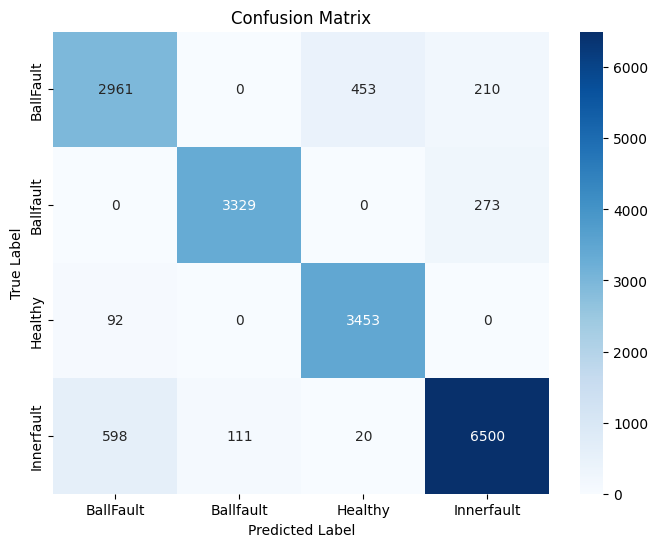

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [5]:
# Create a DataFrame to examine misclassified samples
results_df = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_pred, 'Data': X_test.tolist()})
misclassified = results_df[results_df['True Label'] != results_df['Predicted Label']]

print("Misclassified samples:")
print(misclassified)

Misclassified samples:
       True Label Predicted Label  \
31944   BallFault         Healthy   
41029  Innerfault       BallFault   
34708   BallFault         Healthy   
29542   BallFault         Healthy   
43540  Innerfault       BallFault   
...           ...             ...   
27334   BallFault         Healthy   
43677  Innerfault       BallFault   
11118     Healthy       BallFault   
35087   BallFault         Healthy   
16437   Ballfault      Innerfault   

                                                    Data  
31944  [0.23297648260067627, -0.4925981094077897, 0.0...  
41029  [0.22888275568086328, -0.48453561329975187, -1...  
34708  [-0.08496965374291283, -0.4976274207582469, -0...  
29542  [0.021770489328787924, -0.4932996983201737, 2....  
43540  [-0.17467786955603923, -0.487857798015656, 0.8...  
...                                                  ...  
27334  [0.00054375741702417, -0.4926486997228864, 0.1...  
43677  [-0.1524403407087789, -0.4819067162469716, -0....  
1

Selected Features: Index(['mean', 'variance', 'kurtosis', 'peak_amplitude', 'total_energy',
       'signal_entropy', 'dominant_frequency'],
      dtype='object')
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Classification Report:
              precision    recall  f1-score   support

   BallFault       0.83      0.93      0.88      3624
   Ballfault       0.96      0.93      0.94      3602
     Healthy       0.98      0.99      0.98      3545
  Innerfault       0.94      0.89      0.92      7229

    accuracy                           0.93     18000
   macro avg       0.93      0.94      0.93     18000
weighted avg       0.93      0.93      0.93     18000

F1 Score: 0.9279698218465428


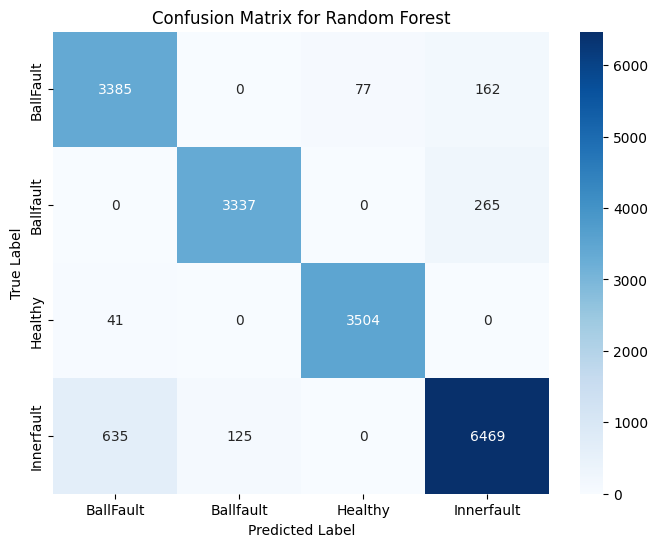

In [6]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'X' as features and 'y' as labels
# X, y = data.drop('label', axis=1), data['label']  # replace with actual column names

# 1. Advanced Feature Extraction with FFT, Energy, and Entropy
def extract_frequency_features(signal):
    fft_values = np.abs(fft(signal))  # FFT values for frequency analysis
    total_energy = np.sum(fft_values ** 2)  # Signal Energy
    signal_entropy = entropy(fft_values)  # Signal Entropy
    dominant_frequency = np.argmax(fft_values)  # Dominant frequency in signal
    return total_energy, signal_entropy, dominant_frequency

# Apply feature extraction to each row in X
frequency_features = np.array([extract_frequency_features(row) for row in X.values])
freq_df = pd.DataFrame(frequency_features, columns=['total_energy', 'signal_entropy', 'dominant_frequency'])
X = pd.concat([X, freq_df], axis=1)

# 2. Feature Selection using SelectKBest
# Standardize the features for better selection and model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Select top k features based on ANOVA F-value
k_best = min(7, X.shape[1])  # Adjusting k to be at most the number of features
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support(indices=True)]
print("Selected Features:", selected_features)

# 3. Model Training and Hyperparameter Tuning with Random Forest
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [10, 15, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'class_weight': ['balanced']  # Handling class imbalance
}

# Initialize Random Forest Classifier with GridSearchCV
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_clf, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_selected, y)

# Get the best Random Forest model
best_rf_clf = grid_search.best_estimator_

# 4. Final Evaluation on Test Data
# Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=30)

# Train the model and evaluate
best_rf_clf.fit(X_train, y_train)
y_pred = best_rf_clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()